In [1584]:
import pickle
import matplotlib.pyplot as plt
import torch
import io, math
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from s2aenso.utils import data, normalization, metric
from s2aenso.utils.utilities import *

PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/"

colors_swin = ['#1410F2', '#068c08', '#076612', '#c28b0a', '#8a0a6e', '#04c4a7', '#e038b1', '#e9f542', '#e9f542', '#ff5733', '#33ff57', '#3357ff', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833','#ff5733', '#33ff57', '#3357ff', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833' ]
colors_vit = ['#D42E07', '#1410F2', '#076612', '#c28b0a', '#8a0a6e', '#04c4a7', '#e038b1', '#e9f542', '#e9f542', '#ff5733', '#33ff57', '#3357ff', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833', '#ff5733', '#33ff57', '#3357ff', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833', '#ff33a8', '#a833ff', '#33ffa8', '#ffa833']


#####################################################################################################################################################################
###------------------------------------------------ Load Models ----------------------------------------------------------------------------------------------------###
#####################################################################################################################################################################


models_swin = [(1102981, "swin_baseline", "SwinLSTM - Baseline")]
#models_swin = []

models_vit = [(1102980, "vit_baseline", "3D-Geoformer - Baseline")]

models_vit_single = [(1102981, "swin_baseline", "SwinLSTM - Baseline")]
models_swin_single = [(1102980, "vit_baseline", "3D-Geoformer - Baseline")]


dataset = "godas"                                   
specification = "paper_baseline"                              
metric_rmse = "nino_rmse_4_l"                       # 'rmse', 'nino_rmse_3_l', 'nino_rmse_34_l', 'nino_rmse_4_l'
metric_ss = "skillscore_mean_4i"                    # 'ss', 'nino_ss_3_l', 'nino_ss_34_l', 'nino_ss_4_l'


save_dir = f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/final_plots/{dataset}/{specification}/"
create_directory(save_dir)



In [1585]:
#####################################################################################################################################################################
###------------------------------------------------ Load Data ----------------------------------------------------------------------------------------------------###
#####################################################################################################################################################################

data_vit = []
data_swinlstm = []

data_vit_single = []
data_swinlstm_single = []

for model_num in models_vit:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_vit_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:
        print("Model name: ", model_num[2])
        cfg_vit = CPU_Unpickler(file).load()
        data_vit.append((cfg_vit, model_num[1]))


for model_num in models_swin:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_swinlstm_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file: 
        print("Model number: ", model_num)  
        cfg_swin = CPU_Unpickler(file).load()
        data_swinlstm.append((cfg_swin, model_num[1]))


# Load single data
for model_num in models_vit_single:
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_vit_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:
        cfg_vit_single = CPU_Unpickler(file).load()
        data_vit_single.append((cfg_vit_single, model_num[1]))

for model_num in models_swin_single:
    print("Model number: ", model_num)
    with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_swinlstm_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:   
        cfg_swin_single = CPU_Unpickler(file).load()
        data_swinlstm_single.append((cfg_swin_single, model_num[1]))



# Load baseline data
model_num_baseline_vit = (765368, "1_2g_schedP", "base")
with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_vit_{model_num_baseline_vit[0]}_{model_num_baseline_vit[1]}.pkl", 'rb') as file:
        baseline_vit = CPU_Unpickler(file).load()
        acc_baseline_vit = np.array(baseline_vit["acc"]["total"][metric_acc])
        print(baseline_vit["loss"].keys())
        rmse_baseline_vit = np.array(baseline_vit["loss"]["total"][metric_rmse])

model_num_baseline_swin = (778521, "new_baseline")
with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset}/results_swinlstm_{model_num_baseline_swin[0]}_{model_num_baseline_swin[1]}.pkl", 'rb') as file:   
        baseline_swin = CPU_Unpickler(file).load()
        acc_baseline_swin = np.array(baseline_swin["acc"]["total"][metric_acc])
        rmse_baseline_swin = np.array(baseline_swin["loss"]["total"][metric_rmse])

Model name:  base
Model name:  7_level_$s\tau_xy$
Model name:  sst
Model number:  (778521, 'new_baseline', 'base_swin')
dict_keys(['subsample_44', 'subsample_89', 'subsample_133', 'subsample_178', 'subsample_223', 'subsample_267', 'subsample_312', 'subsample_356', 'subsample_401', 'subsample_446', 'total'])


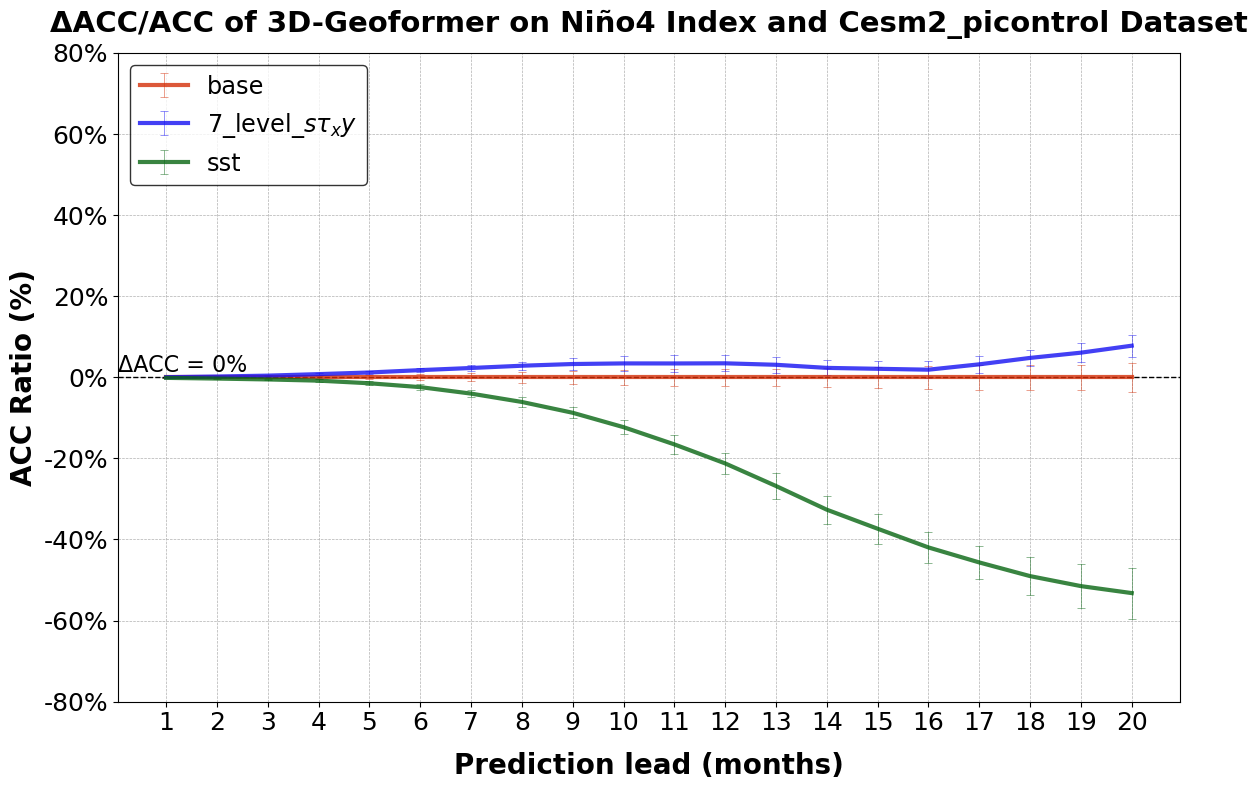

In [1586]:
# ===========================================================================================================================
# Delta ACC/ACC Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through SwinLSTM data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for SwinLSTM model
    mean_swin, std_swin = calculate_mean_std(data_swinlstm[i][0]['acc'], metric_acc)

    # Calculate delta ACC and adjust error (std) accordingly
    delta_acc = ((mean_swin - acc_baseline_vit) / acc_baseline_vit) * 100  # Percentage change from baseline
    delta_std = (std_swin / acc_baseline_vit) * 100  # Error adjustment as percentage

    # Plot delta ACC with error bars (increased opacity only for error bars)
    ax.errorbar(range(0, len(mean_swin)), delta_acc, yerr=delta_std, label=f'{cfg[2]}', 
                color=colors_swin[i], linestyle='-', linewidth=3, alpha=0.8, capsize=3, ecolor=(colors_swin[i]), elinewidth=0.4, capthick=0.4)

# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for ViT model
    mean_vit, std_vit = calculate_mean_std(data_vit[i][0]['acc'], metric_acc)

    # Calculate delta ACC and adjust error (std) accordingly
    delta_acc = ((mean_vit - acc_baseline_vit) / acc_baseline_vit) * 100  # Percentage change from baseline
    delta_std = (std_vit / acc_baseline_vit) * 100  # Error adjustment as percentage

    # Plot delta ACC with error bars (increased opacity only for error bars)
    ax.errorbar(range(0, len(mean_vit)), delta_acc, yerr=delta_std, label=f'{cfg[2]}', 
                color=colors_vit[i], linestyle='-', linewidth=3, alpha=0.8, capsize=3, ecolor=(colors_vit[i]), elinewidth=0.4, capthick=0.4)

# Add a dashed line at y = 0 to indicate no change
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.text(x=1.6, y=0, s='ΔACC = 0%', color='black', fontsize=16, 
        verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='upper left', fontsize='xx-large', title='') # Increase fontsize for legend xx-large
legend.get_frame().set_edgecolor('black')

# Add labels and title with padding
ax.set_xlabel('Prediction lead (months)', fontsize=20, fontweight='bold', labelpad=12)  # Increase labelpad for x-axis label
ax.set_ylabel('ACC Ratio (%)', fontsize=20, fontweight='bold')
ax.set_title(f'ΔACC/ACC of 3D-Geoformer on Niño4 Index and {dataset.capitalize()} Dataset', fontsize=21, fontweight='bold', pad=15)  # Increase pad for title

# Customize the x-axis labels to match the range (e.g., 1-15 months as in the provided image)
num_points = len(data_vit_single[0][0]["acc"]["total"]["acc_mean"])
ax.set_xticks(range(0, num_points, 1))
ax.set_xticklabels(range(1, num_points + 1, 1), fontsize=18)  # Increase fontsize for

# Set y-axis limits and ticks
ax.set_ylim(-80, 80)  # Set y-axis limits to always be between -80 and 80
ax.set_yticks(range(-80, 81, 20))  # Set y-ticks in intervals of 20
ax.set_yticklabels([f'{tick}%' for tick in range(-80, 81, 20)], fontsize=18)  # Increase fontsize for y-ticks

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/delta_acc_comparison_errorbars.pdf')

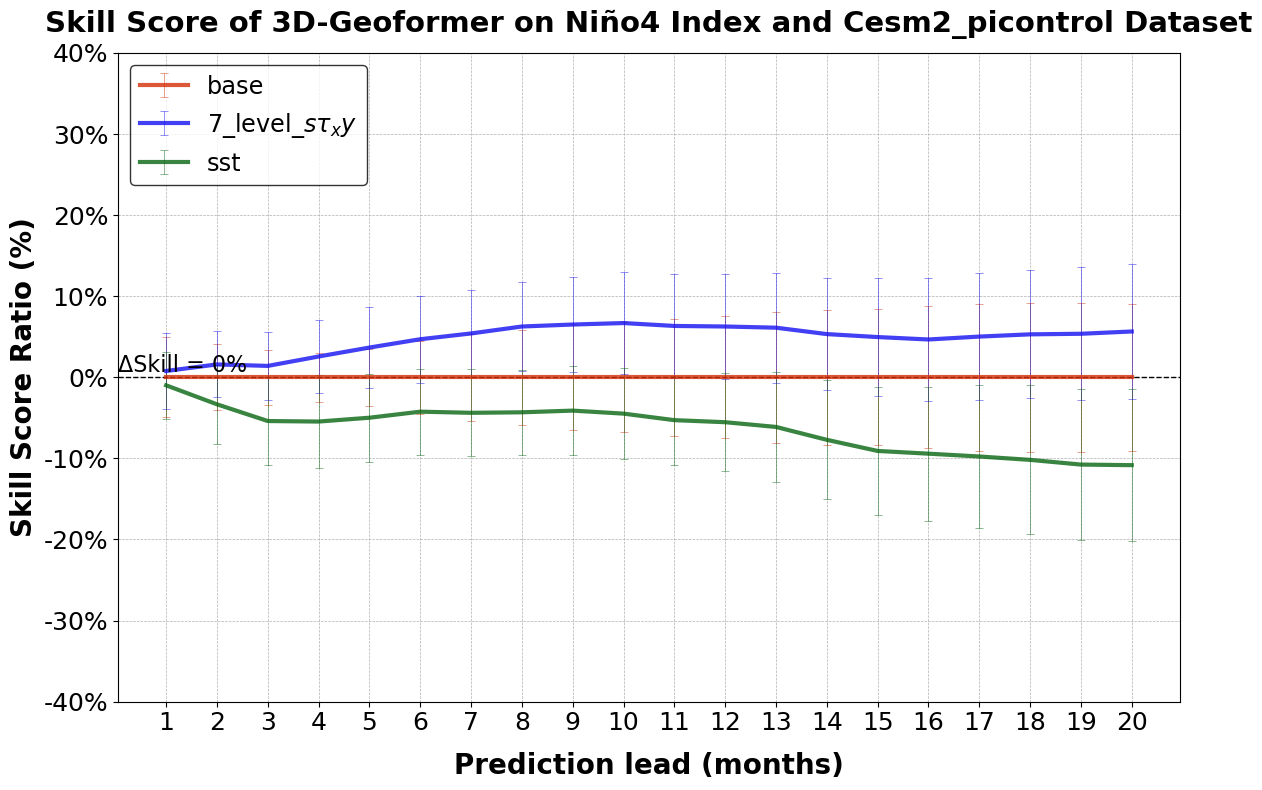

In [1587]:
# ===========================================================================================================================
# Skill Score Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through SwinLSTM data and calculate Skill Score
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for SwinLSTM model
    mean_swin, std_swin = calculate_mean_std(data_swinlstm[i][0]['loss'], metric_rmse)
    rmse_baseline_swin = rmse_baseline_swin  # Baseline RMSE for SwinLSTM

    # Calculate skill score and adjust error (std) accordingly
    skill_score = (1 - (mean_swin / rmse_baseline_vit)) * 100
    skill_std = (std_swin / rmse_baseline_vit) * 100  # Adjust error as a proportion of the baseline RMSE

    # Plot skill score with error bars
    ax.errorbar(range(0, len(mean_swin)), skill_score, yerr=skill_std, label=f'{cfg[2]}',
                color=colors_swin[i], linestyle='-', linewidth=3, alpha=0.8, capsize=3, ecolor=colors_swin[i], elinewidth=0.4, capthick=0.4)

# Loop through ViT data and calculate Skill Score
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for ViT model
    mean_vit, std_vit = calculate_mean_std(data_vit[i][0]['loss'], metric_rmse)
    rmse_baseline_vit = rmse_baseline_vit  # Baseline RMSE for ViT

    # Calculate skill score and adjust error (std) accordingly
    skill_score = (1 - (mean_vit / rmse_baseline_vit)) * 100
    skill_std = (std_vit / rmse_baseline_vit) * 100  # Adjust error as a proportion of the baseline RMSE

    # Plot skill score with error bars
    ax.errorbar(range(0, len(mean_vit)), skill_score, yerr=skill_std, label=f'{cfg[2]}',
                color=colors_vit[i], linestyle='-', linewidth=3, alpha=0.8, capsize=3, ecolor=colors_vit[i], elinewidth=0.4, capthick=0.4)

# Add a dashed line at y = 0 to indicate no skill
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.text(x=1.6, y=0, s='ΔSkill = 0%', color='black', fontsize=16,
        verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='upper left', fontsize='xx-large', title='', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title with padding
ax.set_xlabel('Prediction lead (months)', fontsize=20, fontweight='bold', labelpad=12)  # Increase labelpad for x-axis label
ax.set_ylabel('Skill Score Ratio (%)', fontsize=20, fontweight='bold')
ax.set_title(f'Skill Score of 3D-Geoformer on Niño4 Index and {dataset.capitalize()} Dataset', fontsize=21, fontweight='bold', pad=15)

# Customize the x-axis labels to match the range (e.g., 1-15 months as in the provided image)
num_points = len(mean_vit)
ax.set_xticks(range(0, num_points, 1))
ax.set_xticklabels(range(1, num_points + 1, 1), fontsize=18)  # Increase fontsize for x-ticks

# Set y-axis limits and ticks
ax.set_ylim(-40, 40)  # Set y-axis limits to always be between -0.5 and 0.5
ax.set_yticks(np.arange(-40, 41, 10))  # Set y-ticks in intervals of 0.1
ax.set_yticklabels([f'{tick}%' for tick in np.arange(-40, 41, 10)], fontsize=18)  # Increase fontsize for y-ticks


# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/delta_skillscore_comparison_errorbars.pdf')

monthly_acc:  dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
monthly_acc:  dict_keys(['acc_mean', 'acc_mean_3i', 'acc_mean_34i', 'acc_mean_4i', 'acc_mean_spatial', 'acc_mean_3i_spatial', 'acc_mean_34i_spatial', 'acc_mean_4i_spatial'])


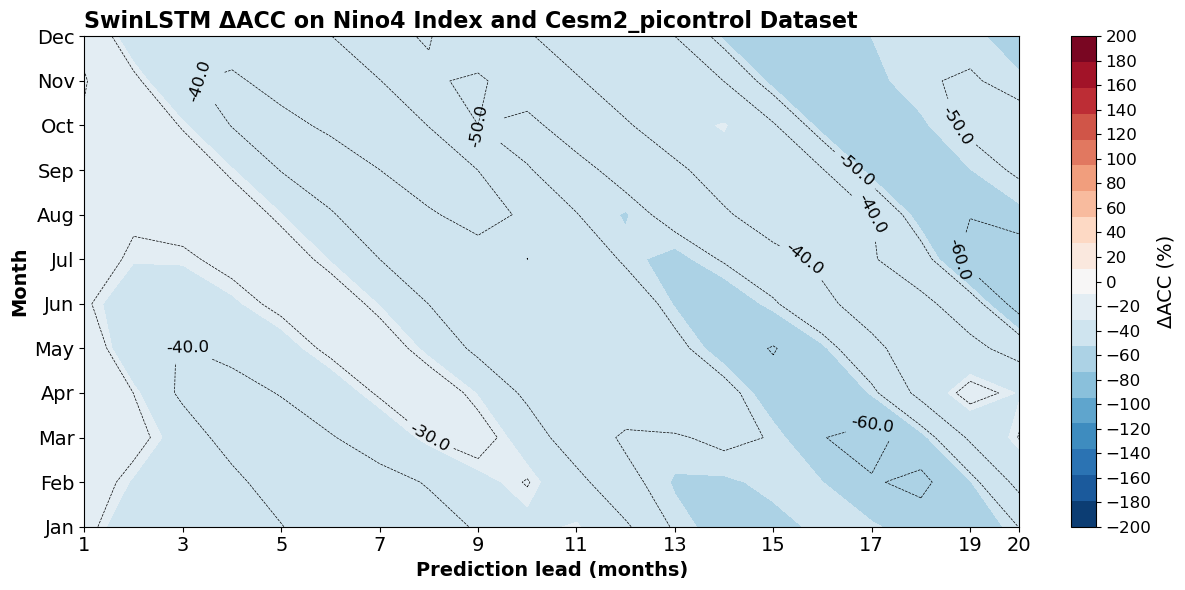

In [1588]:

# ===========================================================================================================================
# Monthly Delta ACC Plot
# ===========================================================================================================================


monthly_acc = data_swinlstm_single[0][0]["monthly_acc"]# #data_swinlstm_single[0][0]["monthly_acc"]
monthly_acc_baseline_swin = baseline_swin["monthly_acc"]
monthly_acc_baseline_vit = baseline_vit["monthly_acc"]
print("monthly_acc: ", monthly_acc.keys())
print("monthly_acc: ", monthly_acc[1].keys())


title = f"SwinLSTM ΔACC on Nino4 Index and {dataset.capitalize()} Dataset"

# Initialize an empty list to store delta ACC values for each month
delta_acc_values = []

# Loop through each month (from 1 to 12)
for i in range(1, 13):
    acc_values = np.array(monthly_acc[i][metric_acc])
    acc_values_baseline = np.array(monthly_acc_baseline_vit[i][metric_acc])
    delta_acc = ((acc_values - acc_values_baseline) / acc_values_baseline) * 100
    delta_acc_values.append(delta_acc)  # Append the result to the list

# Convert delta_acc_values to a 2D numpy array for contour plotting
delta_acc_values = np.array(delta_acc_values)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

levels = np.linspace(-200, 200, 20)
levels_lines = np.linspace(-100, 100, 21)
#levels = None

# Plot the contours using the delta ACC data
# Use a filled contour plot
cmap = 'RdBu_r'  # Red-Blue colormap, reversed
contour = ax.contourf(np.arange(0, 20), np.arange(1, 13), delta_acc_values, levels=levels, cmap=cmap)

# Add contour lines
contour_lines = ax.contour(np.arange(0, 20), np.arange(1, 13), delta_acc_values, levels=levels_lines, colors='black', linewidths=0.5)
ax.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# Set x and y axis labels
ax.set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')
ax.set_ylabel('Month', fontsize=14, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit_single[0][0]["monthly_acc"][1]['acc_mean'])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 21, 2)) + [20], fontsize=14)  # Increase fontsize for x-ticks

ax.set_yticks(np.arange(1, 13, step=1))  # All 12 months
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)

# Add a title
ax.set_title(title, fontsize=16, loc='left', fontweight='bold')

# Add color bar to the right of the plot
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, fraction=0.05)
cbar.set_label('ΔACC (%)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Define the ticks for the color bar, increasing by 5%
cbar.set_ticks(np.arange(cbar.vmin, cbar.vmax + 5, 20))

# Add grid lines for clarity
ax.grid(False)

# Adjust layout to match the style more closely
plt.tight_layout()

# Save the figure (for publication-quality output)
plt.savefig(f'{save_dir}/delta_acc_monthly_contour_plot.pdf')

# Show the plot
plt.show()

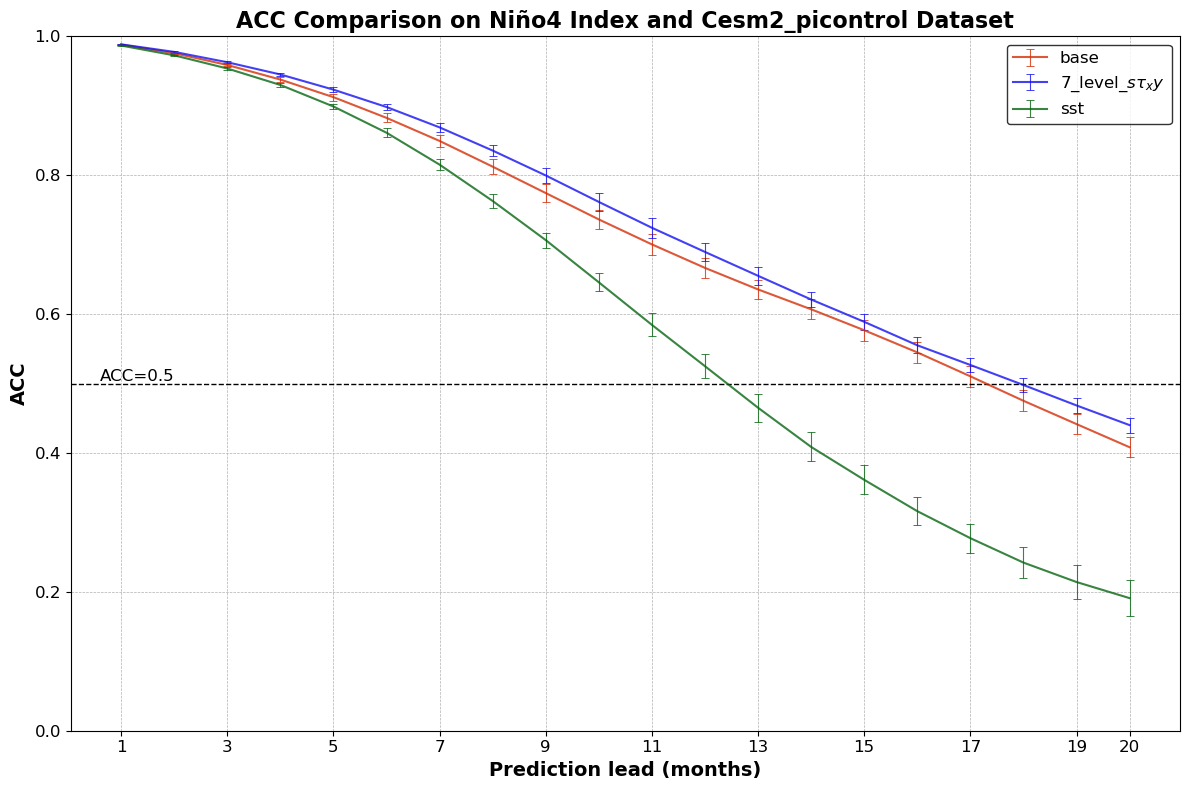

In [1589]:
# ===========================================================================================================================
# Delta ACC/ACC Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

#models_swin = []
# Loop through SwinLSTM data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for SwinLSTM model
    mean_swin, std_swin = calculate_mean_std(data_swinlstm[i][0]['acc'], metric_acc)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_swin)), mean_swin, yerr=std_swin, label=f'{cfg[2]}', 
                color=colors_swin[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_swin[i]), elinewidth=0.8, capthick=0.7)

# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for ViT model
    mean_vit, std_vit = calculate_mean_std(data_vit[i][0]['acc'], metric_acc)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_vit)), mean_vit, yerr=std_vit, label=f'{cfg[2]}', 
                color=colors_vit[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_vit[i]), elinewidth=0.8, capthick=0.7)

# Add a dashed line at y = 0.5 with a label
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')
ax.set_ylabel('ACC', fontsize=14, fontweight='bold')
ax.set_title(f'ACC Comparison on Niño4 Index and {dataset.capitalize()} Dataset', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of the ACC values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Set y-axis limits and ticks
ax.set_ylim(0.0, 1.0)  
ax.set_yticks(np.arange(0.0, 1.1, 0.2))  

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/acc_comparison_errorbars.pdf')

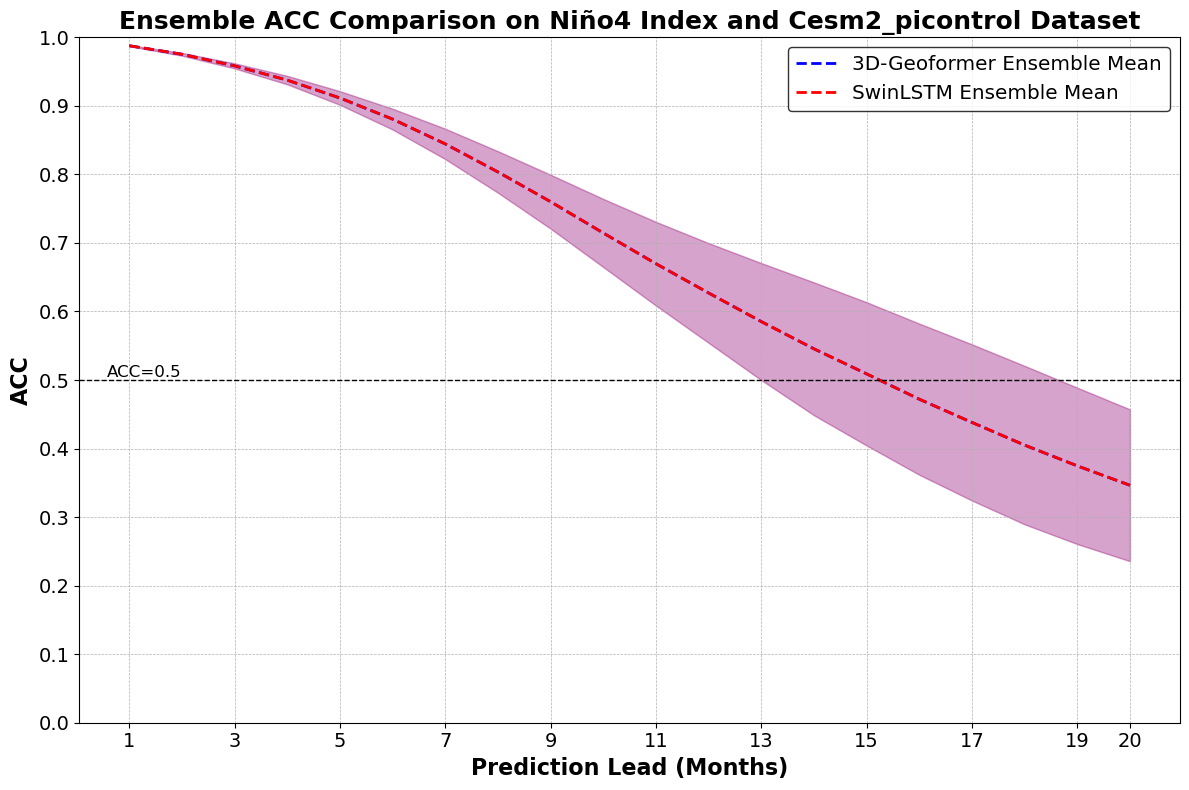

In [1590]:
# ===========================================================================================================================
# Delta ACC/ACC Comparison with Ensemble Members
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize lists to store the mean and std across all ensemble members
ensemble_means = []
ensemble_stds = []

# Aggregate SwinLSTM and ViT models as ensemble members
all_models = models_swin + models_vit
all_data = data_swinlstm + data_vit
all_colors = colors_swin + colors_vit

# Loop through all models in the ensemble
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for the current model
    mean_model, std_model = calculate_mean_std(data_vit[i][0]['acc'], metric_acc)
    
    # Append to the ensemble lists
    ensemble_means.append(mean_model)
    ensemble_stds.append(std_model)


# Calculate overall ensemble mean and spread
ensemble_mean = np.mean(ensemble_means, axis=0)
ensemble_std = np.std(ensemble_means, axis=0)

# Plot the ensemble mean with shaded region for spread
ax.plot(range(0, len(ensemble_mean)), ensemble_mean, color='blue', linestyle='--', linewidth=2, label='3D-Geoformer Ensemble Mean')
ax.fill_between(range(0, len(ensemble_mean)), ensemble_mean - ensemble_std, ensemble_mean + ensemble_std, 
                color='blue', alpha=0.2)


# Loop through all models in the ensemble
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for the current model
    mean_model, std_model = calculate_mean_std(data_swinlstm[i][0]['acc'], metric_acc)
    
    # Append to the ensemble lists
    ensemble_means.append(mean_model)
    ensemble_stds.append(std_model)


# Calculate overall ensemble mean and spread
ensemble_mean = np.mean(ensemble_means, axis=0)
ensemble_std = np.std(ensemble_means, axis=0)

# Plot the ensemble mean with shaded region for spread
ax.plot(range(0, len(ensemble_mean)), ensemble_mean, color='red', linestyle='--', linewidth=2, label='SwinLSTM Ensemble Mean')
ax.fill_between(range(0, len(ensemble_mean)), ensemble_mean - ensemble_std, ensemble_mean + ensemble_std, 
                color='red', alpha=0.2)

# Add a dashed line at y = 0.5 with a label
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='x-large', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Prediction Lead (Months)', fontsize=16, fontweight='bold')
ax.set_ylabel('ACC', fontsize=16, fontweight='bold')
ax.set_title(f'Ensemble ACC Comparison on Niño4 Index and {dataset.capitalize()} Dataset', fontsize=18, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(ensemble_mean)  # Use the length of the ACC values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels([tick + 1 for tick in x_ticks], fontsize=14)  # Adjust labels to start at 1

# Set y-axis limits and ticks
ax.set_ylim(0.0, 1.0)  
ax.set_yticks(np.arange(0.0, 1.1, 0.1)) 
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0.0, 1.1, 0.1)], fontsize=14)  # Adjust labels to show one decimal place 


# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/ensemble_acc_comparison.pdf')

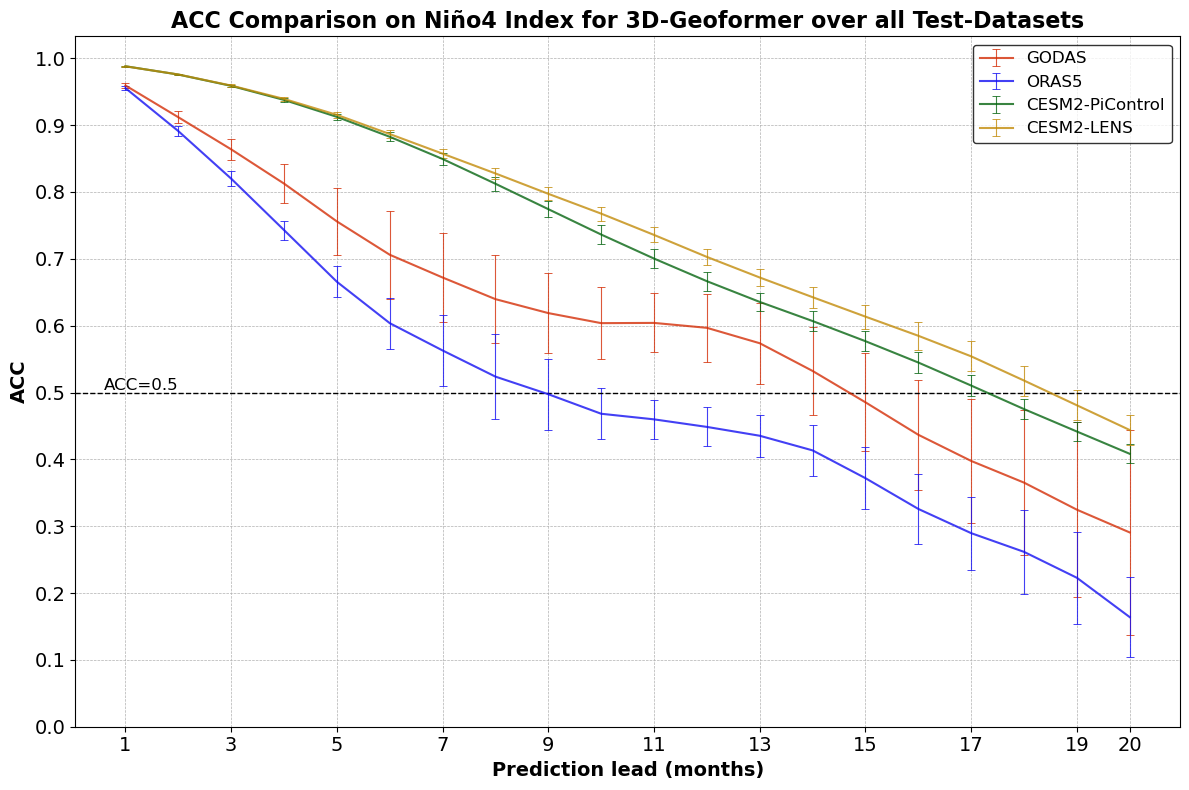

In [1591]:

data_vit_single = []
datasetss = ["godas", "oras5", "cesm2_picontrol", "cesm2_lens"]
labels = ["GODAS", "ORAS5", "CESM2-PiControl", "CESM2-LENS"]
for dataset_ in datasetss:

    # Load single data
    for model_num in models_vit_single:
        with open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/unprocessed/{dataset_}/results_vit_{model_num[0]}_{model_num[1]}.pkl", 'rb') as file:
            cfg_vit_single = CPU_Unpickler(file).load()
            data_vit_single.append((cfg_vit_single, model_num[1]))



# ===========================================================================================================================
# Delta ACC/ACC Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

models_swin = []
# Loop through SwinLSTM data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for SwinLSTM model
    mean_swin, std_swin = calculate_mean_std(data_swinlstm_single[i][0]['acc'], metric_acc)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_swin)), mean_swin, yerr=std_swin, label=f'{labels[i]}', 
                color=colors_swin[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_swin[i]), elinewidth=0.8, capthick=0.7)

# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(data_vit_single):
    # Get mean and standard deviation for ViT model
    mean_vit, std_vit = calculate_mean_std(data_vit_single[i][0]['acc'], metric_acc)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_vit)), mean_vit, yerr=std_vit, label=f'{labels[i]}', 
                color=colors_vit[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_vit[i]), elinewidth=0.8, capthick=0.7)

# Add a dashed line at y = 0.5 with a label
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')
ax.set_ylabel('ACC', fontsize=14, fontweight='bold')
ax.set_title(f'ACC Comparison on Niño4 Index for 3D-Geoformer over all Test-Datasets', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of the ACC values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20], fontsize=11)  # Adjust labels to start

# Set y-axis limits and ticks
#ax.set_ylim(0.0, 1.1)  
ax.set_yticks(np.arange(0.0, 1.1, 0.1))  
#ax.set_yticklabels(np.arange(0.0, 1.1, 0.1), fontsize=11)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/acc_comparison_datasets_errorbars.pdf')

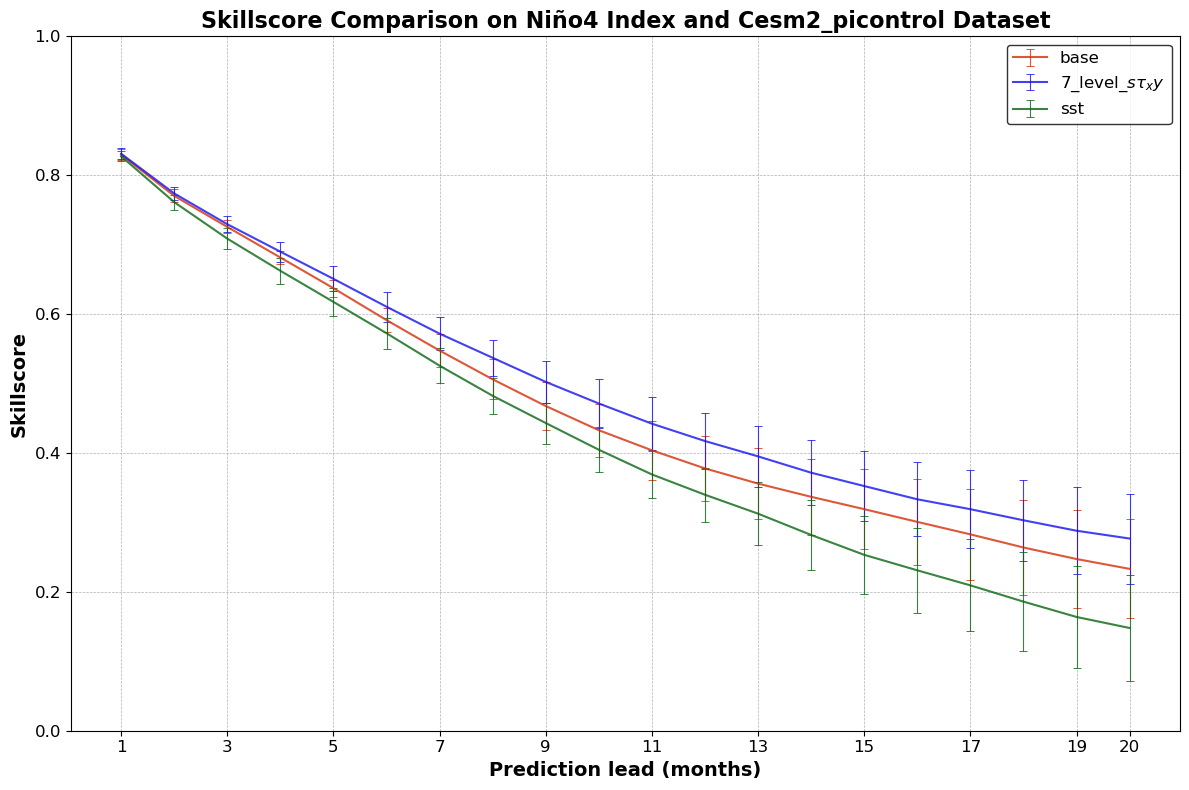

In [1592]:
# ===========================================================================================================================
# Skillscore Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

#models_swin = []
# Loop through SwinLSTM data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_swin):
    # Get mean and standard deviation for SwinLSTM model
    mean_swin, std_swin = calculate_mean_std(data_swinlstm[i][0]['skillscore'], metric_ss)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_swin)), mean_swin, yerr=std_swin, label=f'{cfg[2]}', 
                color=colors_swin[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_swin[i]), elinewidth=0.8, capthick=0.7)

# Loop through ViT data and calculate Delta ACC/ACC
for i, cfg in enumerate(models_vit):
    # Get mean and standard deviation for ViT model
    mean_vit, std_vit = calculate_mean_std(data_vit[i][0]['skillscore'], metric_ss)

    # Plot delta ACC with error bars
    ax.errorbar(range(0, len(mean_vit)), mean_vit, yerr=std_vit, label=f'{cfg[2]}', 
                color=colors_vit[i], linestyle='-', alpha=0.8, capsize=3, ecolor=(colors_vit[i]), elinewidth=0.8, capthick=0.7)

# Add a dashed line at y = 0.5 with a label
#ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
#ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')
ax.set_ylabel('Skillscore', fontsize=14, fontweight='bold')
ax.set_title(f'Skillscore Comparison on Niño4 Index and {dataset.capitalize()} Dataset', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of the ACC values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

ax.set_ylim(0.0, 1.0)  
ax.set_yticks(np.arange(0.0, 1.1, 0.2))  

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/skillscore_comparison_errorbars.pdf')

C:\Users\felix\AppData\Local\Temp\ipykernel_29144\1398240510.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 0.9])


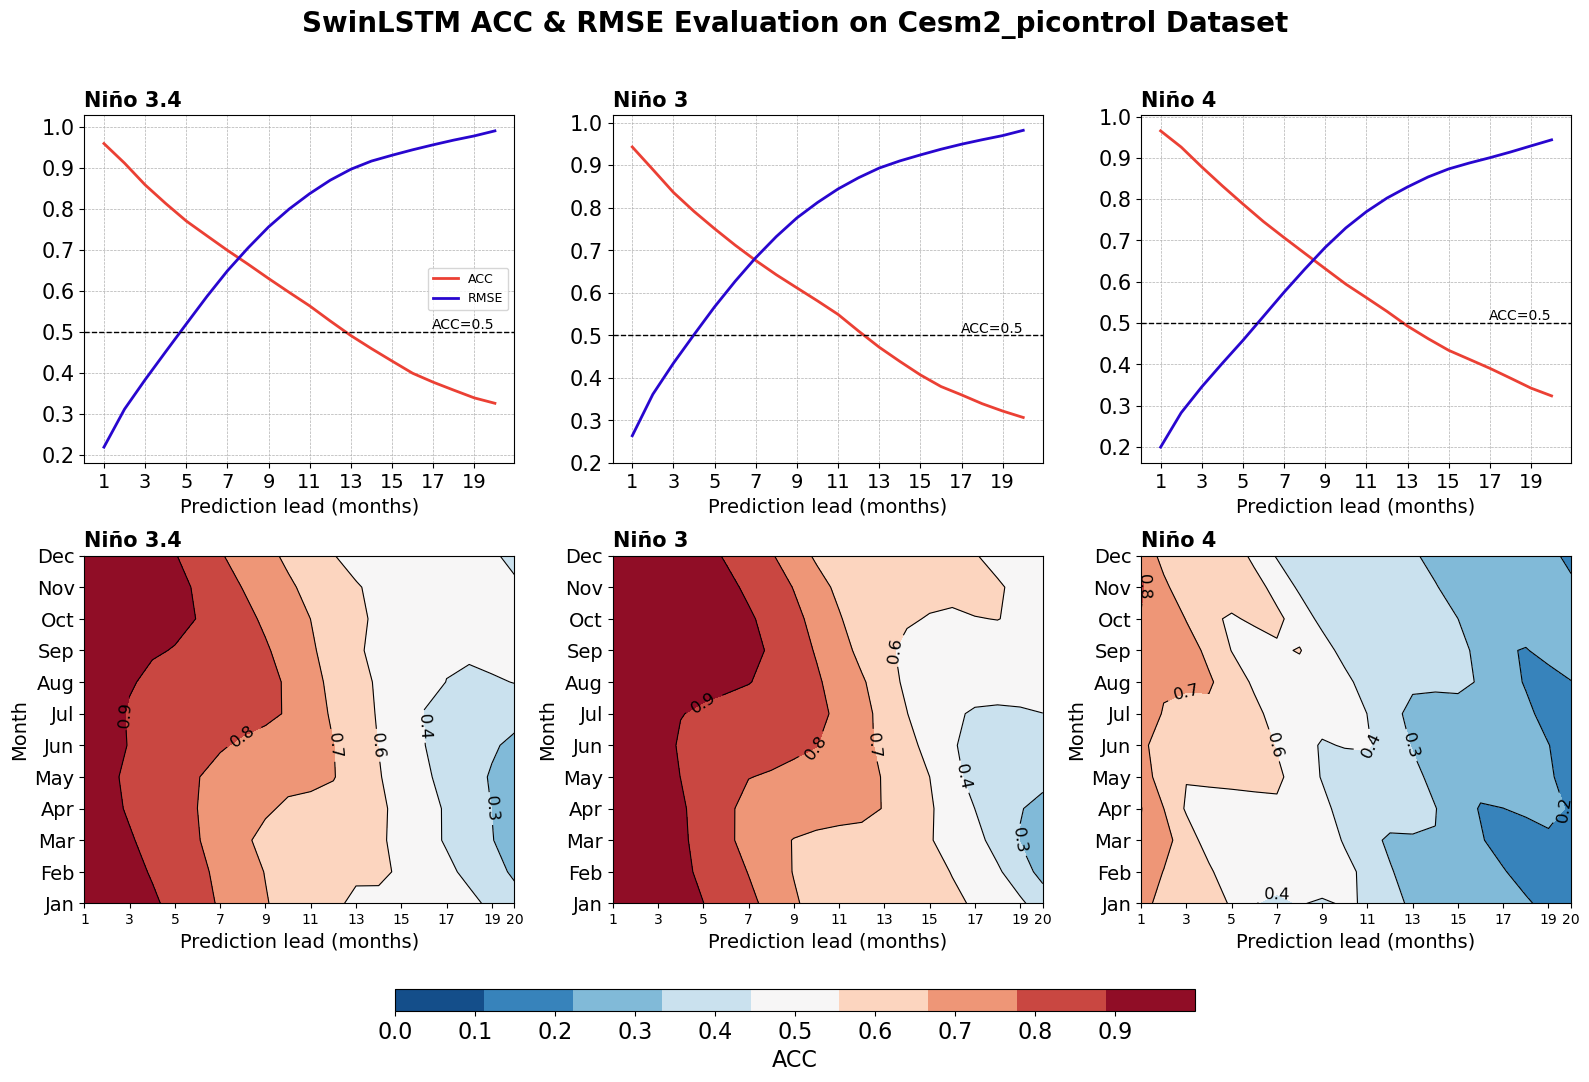

In [1593]:
# Define metrics
metric_acc_ = ["acc_mean_34i", "acc_mean_3i", "acc_mean_4i"]
metric_rmse_ = ['nino_rmse_34_l', 'nino_rmse_3_l', 'nino_rmse_4_l']

# Create figure with a 2x3 grid layout (for 3 line plots and 3 contour plots)
fig, axs = plt.subplots(2, 3, figsize=(16, 11), gridspec_kw={'height_ratios': [1, 1]})
fig.suptitle(f'SwinLSTM ACC & RMSE Evaluation on {dataset.capitalize()} Dataset', fontsize=20, fontweight='bold', y=0.92)

# Plot settings
niño_indices = ["Niño 3.4", "Niño 3", "Niño 4"]
colors = {"ACC": "#eb4034", "RMSE": "#2806cf", "MAE": "#ff6f91"}

for i, (metric_acc, metric_rmse) in enumerate(zip(metric_acc_, metric_rmse_)):
    ax = axs[0, i]

    # Plot ACC and RMSE for each Niño index
    mean_acc, std_vit = calculate_mean_std(data_swinlstm_single[0][0]['acc'], metric_acc)
    mean_rmse, std_vit_rmse = calculate_mean_std(data_swinlstm_single[0][0]['loss'], metric_rmse)

    ax.plot(range(0, len(mean_acc)), mean_acc, label="ACC", color=colors["ACC"], linewidth=2)
    ax.plot(range(0, len(mean_acc)), mean_rmse, label="RMSE", color=colors["RMSE"], linewidth=2)
    
    # Add a dashed line at y = 0.5
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
    ax.text(19, 0.5, 'ACC=0.5', color='black', fontsize=10, verticalalignment='bottom', horizontalalignment='right')

    # Set labels, title, and grid
    ax.set_xlabel('Prediction lead (months)', fontsize=14)
    ax.set_title(niño_indices[i], fontsize=15, loc='left', fontweight='bold')
    ax.set_xticks(range(0, len(mean_acc), 2))
    ax.set_xticklabels(range(1, len(mean_acc) + 1, 2), fontsize=14)
    ax.set_yticks(np.arange(0.2, 1.1, 0.1))
    ax.set_yticklabels(np.round(np.arange(0.2, 1.1, 0.1), 1), fontsize=15)
    ax.grid(True, linestyle='--', linewidth=0.5)

# Adjust legend for the top-left plot
axs[0, 0].legend(loc='center right', fontsize=9)

# ===========================================================================================================================
# ACC Contour Plots for Monthly Prediction Skill for Each Niño Index
# ===========================================================================================================================

monthly_acc = data_swinlstm_single[0][0]["monthly_acc"] #data_swinlstm_single[0][0]["monthly_acc"]

for i, metric_acc in enumerate(metric_acc_):
    ax = axs[1, i]
    acc_values = np.array([monthly_acc[j][metric_acc] for j in range(1, 13)])
    #print("Acc values: ", acc_values)

    # Plot the contours using the ACC data
    cmap = 'RdBu_r'  # Red-Blue colormap, reversed
    contour = ax.contourf(range(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(0, 1, 10), cmap=cmap)

    # Add contour lines
    contour_lines = ax.contour(range(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(0, 1, 10), colors='black', linewidths=0.8)
    ax.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

    # Set x and y axis labels
    ax.set_xlabel('Prediction lead (months)', fontsize=14)
    ax.set_ylabel('Month', fontsize=14)
    ax.set_yticks(np.arange(1, 13))
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
    # Customize the x-axis labels to start at 1 and end at 20
    num_points = len(data_vit[0][0]["monthly_acc"][1]['acc_mean'])
    x_ticks = list(range(0, num_points, max(1, num_points // 10)))
        # Ensure the last month (20) is included
    if (num_points - 1) not in x_ticks:
        x_ticks.append(num_points - 1)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(range(1, 21, 2)) + [20])
    ax.set_title(niño_indices[i], fontsize=15, loc='left', fontweight='bold')

# Centered colorbar below the entire figure
# Create a new axis for the colorbar below the figure
cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label('ACC', fontsize=16)
cbar.ax.tick_params(labelsize=16)

# Define the ticks for the color bar, increasing by 0.1
cbar.set_ticks(np.arange(0, 1, 0.1))
# Reduce spacing between title and figure
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# Save and show plot
plt.savefig(f'{save_dir}/nino_indices_skill_assessment.pdf')
plt.show()


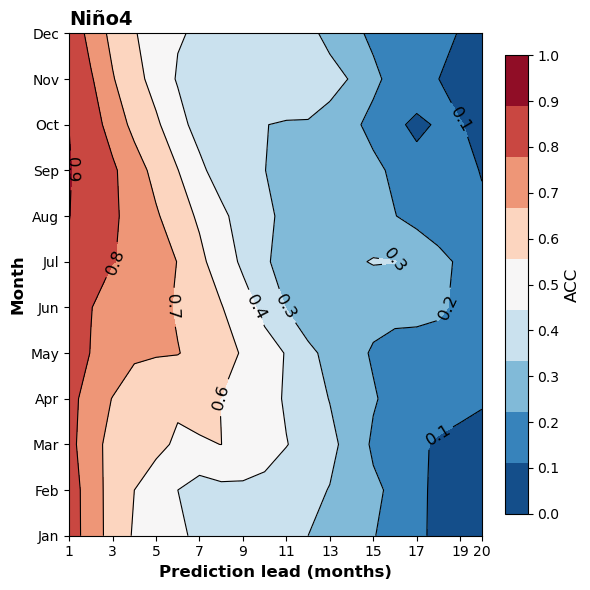

In [1594]:
# ===========================================================================================================================
# Monthly ACC Plot
# ===========================================================================================================================

monthly_acc = data_vit_single[0][0]["monthly_acc"] #data_swinlstm_single[0][0]["monthly_acc"]

title = f"Niño4"

# Prepare data for contour plotting
# Create a 2D array where each row represents a month and each column represents the forecast horizon (lag)
acc_values = np.array([monthly_acc[i]['acc_mean'] for i in range(1, 13)])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the contours using the ACC data
# Use a filled contour plot
cmap = 'RdBu_r'  # Red-Blue colormap, reversed
contour = ax.contourf(np.arange(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(0, 1, 10), cmap=cmap)

# Add contour lines
contour_lines = ax.contour(np.arange(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(0, 1, 10), colors='black', linewidths=0.8)
ax.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# Set x and y axis labels
ax.set_xlabel('Prediction lead (months)', fontsize=12, fontweight='bold')
ax.set_ylabel('Month', fontsize=12, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit[0][0]["monthly_acc"][1]['acc_mean'])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 21, 2)) + [20])

ax.set_yticks(np.arange(1, 13, step=1))  # All 12 months
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# Add a title
ax.set_title(title, fontsize=14, loc='left', fontweight='bold')

# Add color bar to the right of the plot
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, fraction=0.05)
cbar.set_label('ACC', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Define the ticks for the color bar, increasing by 0.1
cbar.set_ticks(np.arange(cbar.vmin, cbar.vmax + 0.1, 0.1))

# Add grid lines for clarity
ax.grid(False)

# Adjust layout to match the style more closely
plt.tight_layout()

# Save the figure (for publication-quality output)
plt.savefig(f'{save_dir}/acc_montly_contour_plot.pdf')

# Show the plot
plt.show()

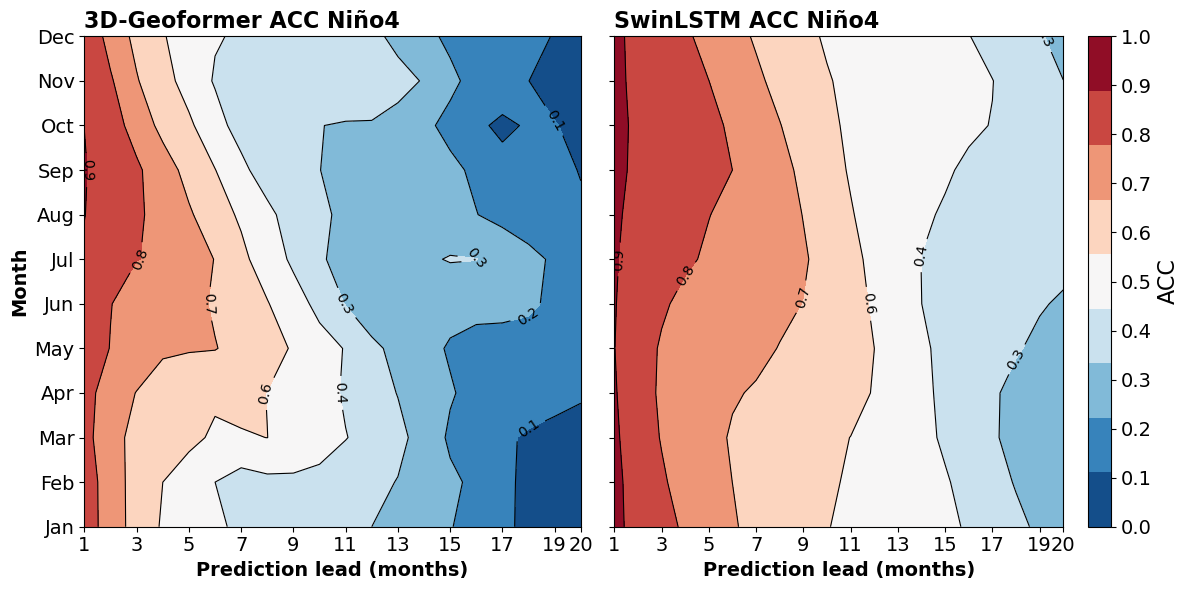

In [1595]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming data_vit and data_swinlstm contain the necessary monthly_acc values
monthly_acc_vit = data_vit_single[0][0]["monthly_acc"]
monthly_acc_swinlstm = data_swinlstm_single[0][0]["monthly_acc"]
title_1 = "3D-Geoformer ACC Niño4"
title_2 = "SwinLSTM ACC Niño4"

# Prepare data for contour plotting for both models
acc_values_vit = np.array([monthly_acc_vit[i]['acc_mean'] for i in range(1, 13)])
acc_values_swinlstm = np.array([monthly_acc_swinlstm[i]['acc_mean'] for i in range(1, 13)])

# Create the figure and axis with 2 columns for both models
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Set a consistent colormap and contour levels
cmap = 'RdBu_r'  # Red-Blue colormap, reversed

# Plot for ViT (Left plot)
contour_vit = axs[0].contourf(np.arange(0, 20), np.arange(1, 13), acc_values_vit, levels=np.linspace(0, 1, 10), cmap=cmap)
contour_lines_vit = axs[0].contour(np.arange(0, 20), np.arange(1, 13), acc_values_vit, levels=np.linspace(0, 1, 10), colors='black', linewidths=0.8)
axs[0].clabel(contour_lines_vit, fmt='%1.1f', inline=True, fontsize=10)
axs[0].set_title(title_1, fontsize=16, loc='left', fontweight='bold')
axs[0].set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Month', fontsize=14, fontweight='bold')

# Plot for SwinLSTM (Right plot)
contour_swinlstm = axs[1].contourf(np.arange(0, 20), np.arange(1, 13), acc_values_swinlstm, levels=np.linspace(0, 1, 10), cmap=cmap)
contour_lines_swinlstm = axs[1].contour(np.arange(0, 20), np.arange(1, 13), acc_values_swinlstm, levels=np.linspace(0, 1, 10), colors='black', linewidths=0.8)
axs[1].clabel(contour_lines_swinlstm, fmt='%1.1f', inline=True, fontsize=10)
axs[1].set_title(title_2, fontsize=16, loc='left', fontweight='bold')
axs[1].set_xlabel('Prediction lead (months)', fontsize=14, fontweight='bold')


axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(list(range(1, 21, 2)) + [20], fontsize=14)
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(list(range(1, 21, 2)) + [20], fontsize=14)

# Customize the y-axis labels to display all months
yticks = np.arange(1, 13)
yticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels, fontsize=14)

# Create a divider for the rightmost plot and add the colorbar to the right of both plots
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.25)  # Increase pad to 0.15 for more spacing

# Add color bar on the right side of the figure (next to the second plot)
cbar = fig.colorbar(contour_swinlstm, cax=cax)
cbar.set_label('ACC', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Define the ticks for the color bar, increasing by 0.1
cbar.set_ticks(np.arange(cbar.vmin, cbar.vmax + 0.1, 0.1))

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure for publication-quality output
plt.savefig(f'{save_dir}/acc_monthly_comparison_vit_swinlstm.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [1596]:
device= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/"


# Load the configuration files
cfg_vit = data_vit_single[0][0]["config"]

# Selecting the data directories
if cfg_vit["temp_ocean"]:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/test/'
else:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/sst_ssh/'

cfg_vit["lsm_path"] = PATH + '/../data/processed_data/enso_data_pacific/land_sea_mask_common.nc'
cfg_vit["oras5_dir"] = PATH + '/../data/processed_data/enso_data_pacific/oras5/'


# Load common land sea mask
common_lsm = xr.open_dataset(cfg_vit['lsm_path'])['lsm'].data
lsm = torch.as_tensor(common_lsm, device = device, dtype = torch.long)


# Load the validation xarray dataset
if cfg_vit["1_2_grid"]:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt_1_2_grid.nc")
else:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt.nc")

lsm = common_lsm[cfg_vit["lat_range"][0]:cfg_vit["lat_range"][1], cfg_vit["lon_range"][0]:cfg_vit["lon_range"][1]]


# Adjust the grid region if 1_2_grid is set to True
if cfg_vit["adjust_grid_region"]:
    val_ds_adapt = val_ds_adapt.sel(lat=slice(-26, 25), lon=slice(148, 279))
    lsm = lsm[:51, 29:95]

In [1597]:
# ===========================================================================================================================
# ACC Spatial Forecast Plot
# ===========================================================================================================================



# Selecting ACC of 12 month forecast
vit_acc = data_vit_single[0][0]["acc"]["total"]["acc_mean_4i_spatial"]
swinlstm_acc = data_swinlstm_single[0][0]["acc"]["total"]["acc_mean_4i_spatial"]


lags = [3, 12, 20]

for lag in lags:
    vit_acc_ = vit_acc[lag-1]
    swinlstm_acc_ = swinlstm_acc[lag-1][:51, :]

    hindcast = dict()
    for key, x in dict(ViT_ACC=vit_acc_, SwinLSTM_ACC=swinlstm_acc_).items():
        hindcast[key] = xr.DataArray(x, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_ACC', 'SwinLSTM_ACC']
    titles = ['ViT_ACC', 'SwinLSTM_ACC']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 0.8

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('ACC', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'ACC Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/acc_comparison_lag_{lag}.pdf')

ValueError: different number of dimensions on data and dims: 1 vs 2

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3600982418.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])
C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3600982418.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])
C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3600982418.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


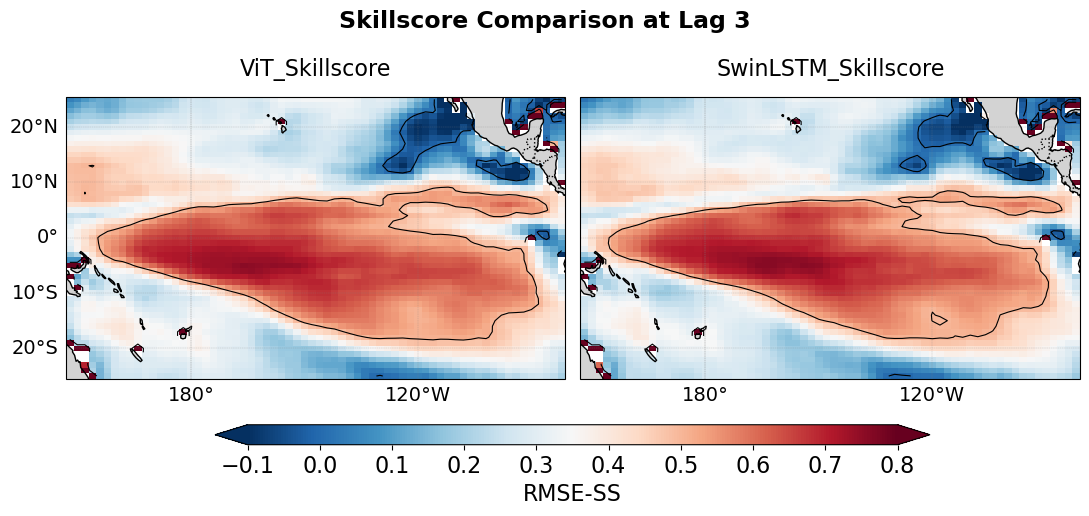

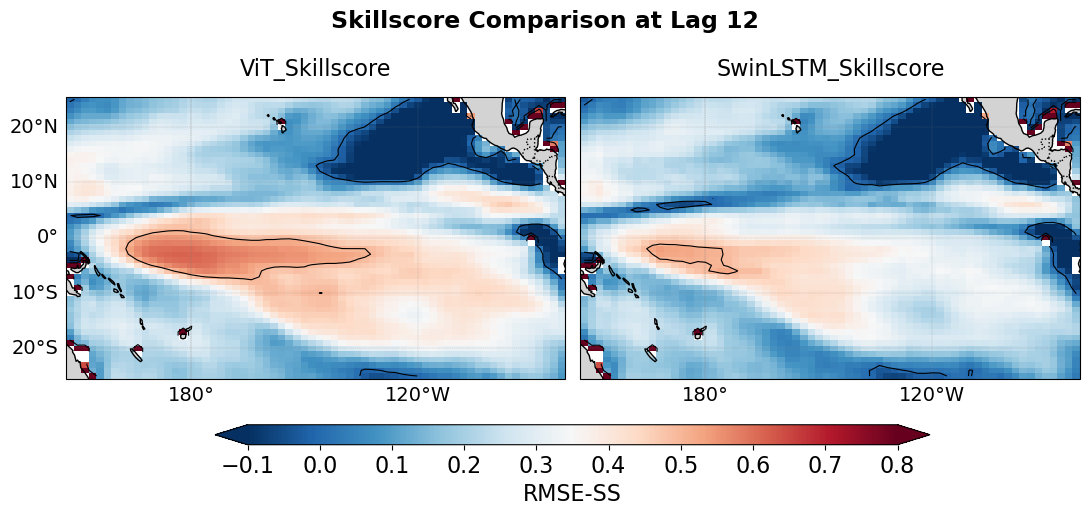

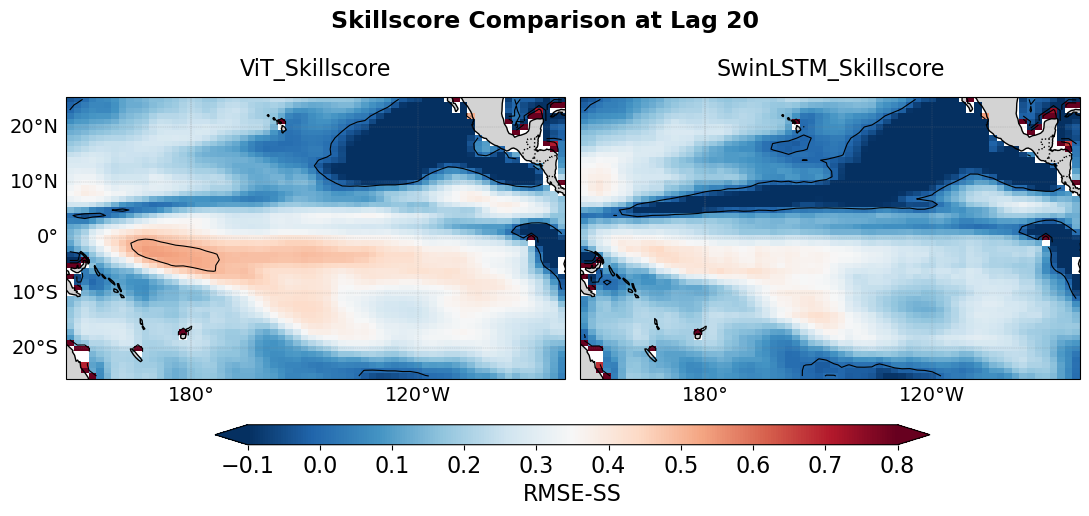

In [120]:
# ===========================================================================================================================
# Skillscore Spatial Forecast Plot
# ===========================================================================================================================

# Selecting Skillscore of 12 month forecast
vit_skillscore = data_vit_single[0][0]["skillscore"]["total"]["skillscore_"]
swinlstm_skillscore = data_swinlstm_single[0][0]["skillscore"]["total"]["skillscore_"]

lags = [3, 12, 20]

for lag in lags:
    vit_skillscore_ = vit_skillscore[lag-1]
    swinlstm_skillscore_ = swinlstm_skillscore[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_Skillscore=vit_skillscore_, SwinLSTM_Skillscore=swinlstm_skillscore_).items():
        hindcast[key] = x

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_Skillscore', 'SwinLSTM_Skillscore']
    titles = ['ViT_Skillscore', 'SwinLSTM_Skillscore']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 0.8

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('RMSE-SS', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'Skillscore Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    #plt.show()
    fig.savefig(f'{save_dir}/skillscore_comparison_lag_{lag}.pdf')

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\2343897947.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


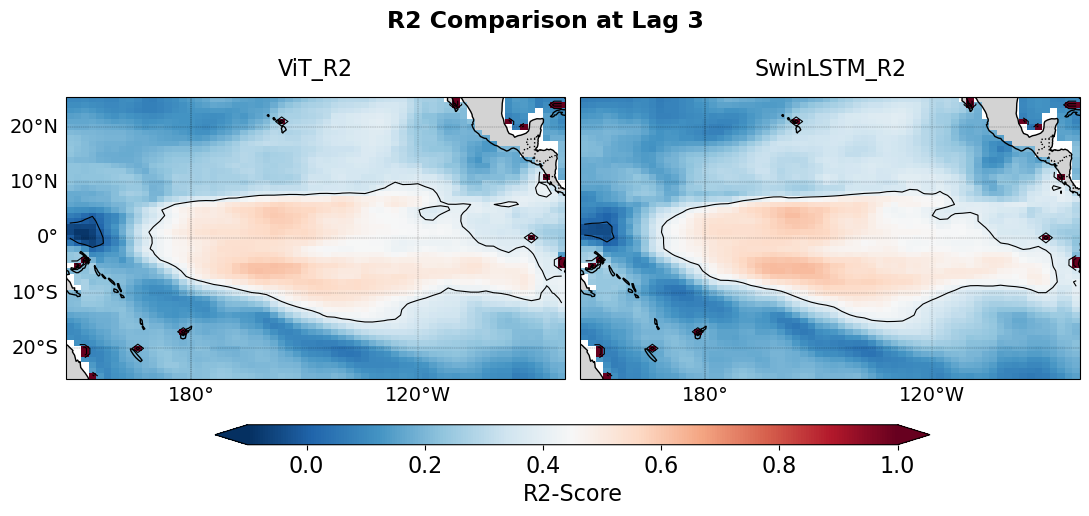

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\2343897947.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


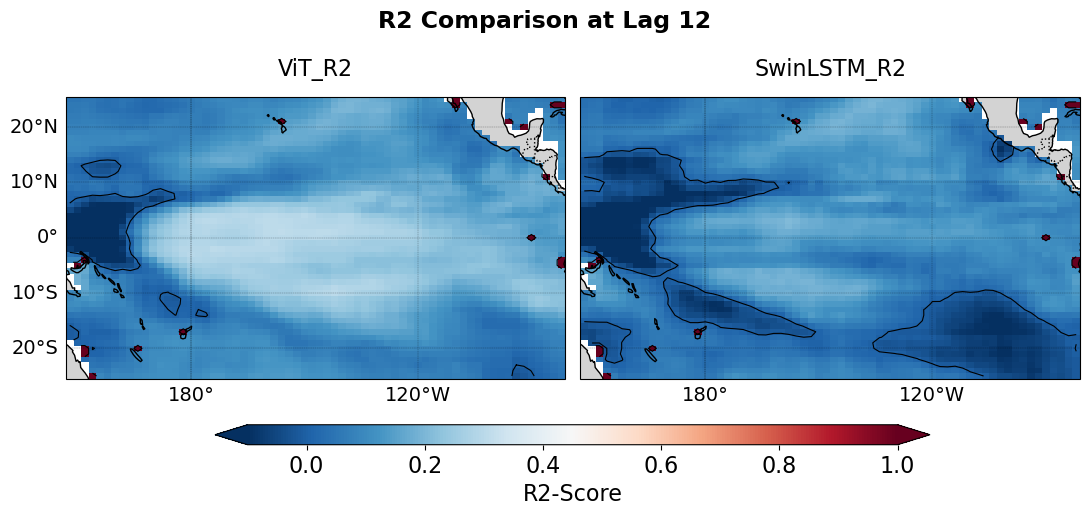

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\2343897947.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


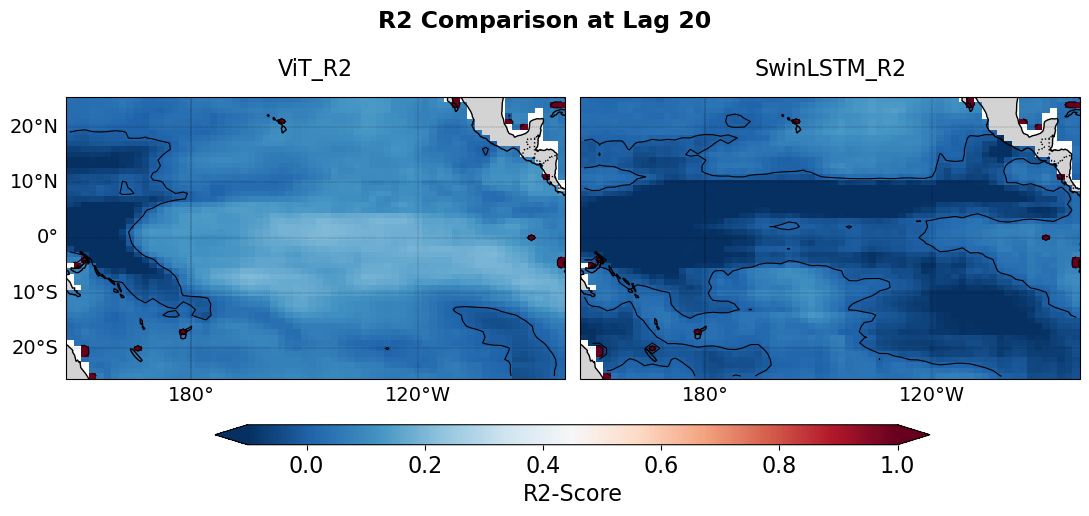

In [121]:
# ===========================================================================================================================
# R2 Spatial Forecast Plot
# ===========================================================================================================================

# Selecting RMSE of 12 month forecast
vit_rmse = data_vit_single[0][0]["loss"]["total"]["rmse_orig"]
swinlstm_rmse = data_swinlstm_single[0][0]["loss"]["total"]["rmse_orig"]

vit_target_std = data_vit_single[0][0]["loss"]["total"]["targ_data_std"]["targets_vit"]
swinlstm_target_std = data_swinlstm_single[0][0]["loss"]["total"]["targ_data_std"]["targets_swinlstm"]

vit_r2 = 1 - (vit_rmse[:, :51, :] / vit_target_std[:, :51, 29:95])
swinlstm_r2 = 1 - (swinlstm_rmse[:, :51, :] / swinlstm_target_std[:, :51, 29:95])

lags = [3, 12, 20]

for lag in lags:

    vit_r2_ = vit_r2[lag-1]
    swinlstm_r2_ = swinlstm_r2[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_R2=vit_r2_, SwinLSTM_R2=swinlstm_r2_).items():
        hindcast[key] = xr.DataArray(x, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_R2', 'SwinLSTM_R2']
    titles = ['ViT_R2', 'SwinLSTM_R2']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 1

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('R2-Score', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'R2 Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/r2_comparison_lag_{lag}.pdf')

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3604224331.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


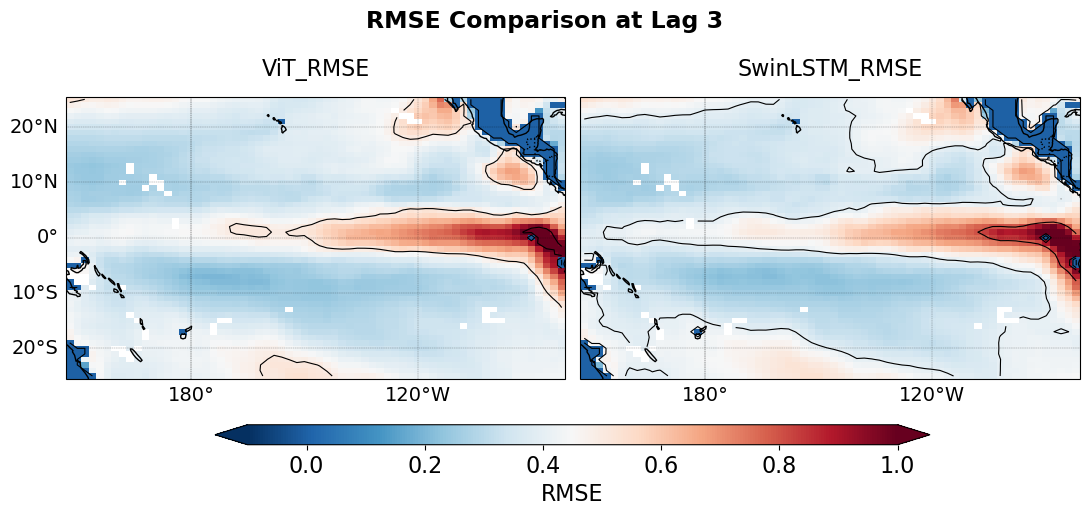

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3604224331.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


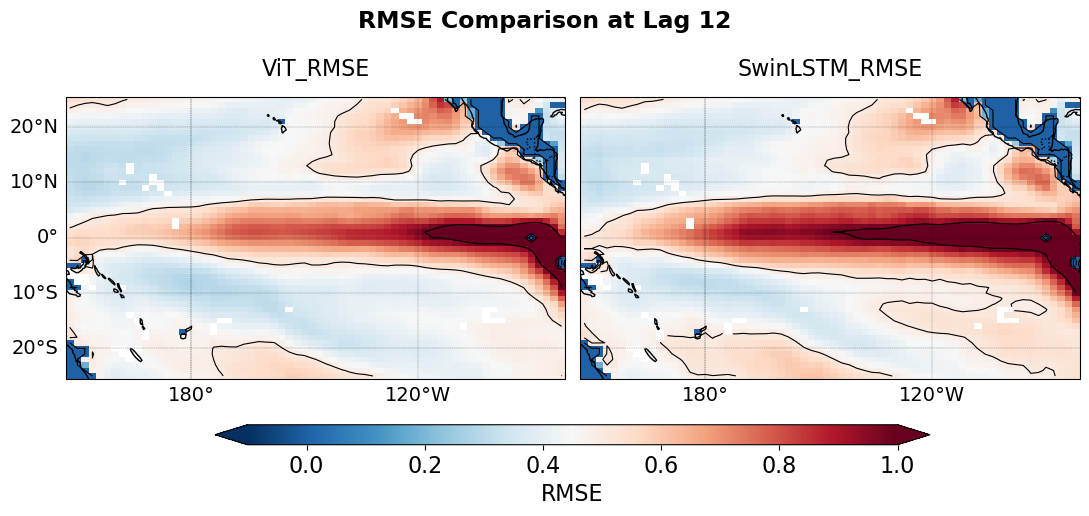

C:\Users\felix\AppData\Local\Temp\ipykernel_28876\3604224331.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


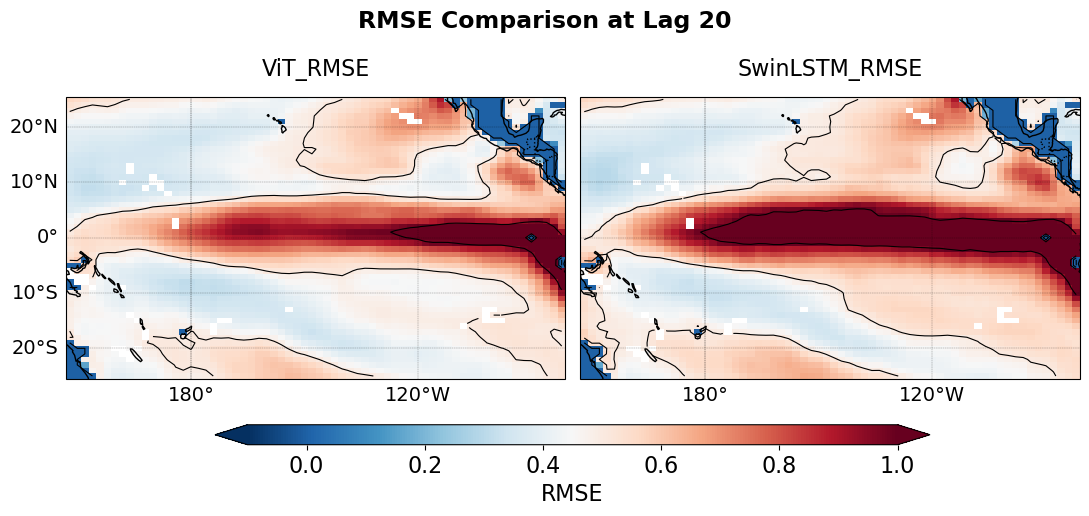

In [122]:
# ===========================================================================================================================
# RMSE Spatial Forecast Plot
# ===========================================================================================================================


# Selecting RMSE of 12 month forecast
vit_rmse = data_vit_single[0][0]["loss"]["total"]["rmse_orig"]
swinlstm_rmse = data_swinlstm_single[0][0]["loss"]["total"]["rmse_orig"]

lags = [3, 12, 20]

for lag in lags:

    vit_rmse_ = vit_rmse[lag-1]
    swinlstm_rmse_ = swinlstm_rmse[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_RMSE=vit_rmse_, SwinLSTM_RMSE=swinlstm_rmse_).items():
    
        x_lst = []
        da = xr.DataArray(
            data=x[:51, :],
            coords=val_ds_adapt.isel(time=0).coords)
        # Mask land
        da = da.where(lsm == 0, other=np.nan)
        hindcast[key] = da

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_RMSE', 'SwinLSTM_RMSE']
    titles = ['ViT_RMSE', 'SwinLSTM_RMSE']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 1

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('RMSE', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'RMSE Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/rmse_comparison_lag_{lag}.pdf')